In [1]:
# !pip install tf-explain

In [2]:
import numpy as np
import keras
from keras import layers
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import utils
from sklearn.utils import class_weight
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras import applications

# Constants
TRAIN_DIR = "/kaggle/input/retinal-oct-sample-zip/train_sample2"
VAL_DIR = "/kaggle/input/retinal-oct-sample-zip/val"
TEST_DIR = "/kaggle/input/retinal-oct-sample-zip/test"
IMG_SIZE = (128, 128)
BATCH_SIZE = 128
EPOCHS = 36
SEED = 127
NUM_CLASSES = 4

# Load datasets
train_ds = keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='grayscale'
)

val_ds = keras.utils.image_dataset_from_directory(
    VAL_DIR,
    # validation_split=0.2,
    # subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='grayscale'
)

test_ds = keras.utils.image_dataset_from_directory(
    TEST_DIR,
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='grayscale'
)

# Function to separate images and labels
def separate_imglabel(dataset):
    x = []
    y = []
    for img_batch, label_batch in dataset:
        x.append(img_batch.numpy())
        y.append(label_batch.numpy())
    x = np.concatenate(x, axis=0)
    y = np.concatenate(y, axis=0)
    return x, y

# Separate images and labels
x_train, y_train = separate_imglabel(train_ds)
x_val, y_val = separate_imglabel(val_ds)
x_test, y_test = separate_imglabel(test_ds)

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_val = x_val.astype("float32") / 255
x_test = x_test.astype("float32") / 255

# Compute class weights using class indices
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Convert class weights to a dictionary
class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict)

# Convert class vectors to binary class matrices (one-hot encoding)
y_train = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_val = keras.utils.to_categorical(y_val, NUM_CLASSES)
y_test = keras.utils.to_categorical(y_test, NUM_CLASSES)

# Print shapes for verification
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)


Found 4000 files belonging to 4 classes.
Found 32 files belonging to 4 classes.
Found 968 files belonging to 4 classes.
Class Weights: {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0}
x_train shape: (4000, 128, 128, 1)
y_train shape: (4000, 4)
x_val shape: (32, 128, 128, 1)
y_val shape: (32, 4)
x_test shape: (968, 128, 128, 1)
y_test shape: (968, 4)


In [3]:
y_val.shape

(32, 4)

In [4]:
# Define the model
import keras_tuner as kt


from tensorflow import keras
from tensorflow.keras import layers

def build_cnn(hp):
    # Define the input layer
    inputs = layers.Input(shape=(128, 128, 1))
    
    # Initialize the first layer
    x = inputs
    
    # Add convolutional layers based on the hyperparameter choice
    n_layers = hp.Choice("n_layers", values=[1, 2, 3])
    for i in range(n_layers):
        x = layers.Conv2D(32 * (i + 1), kernel_size=(3, 3), activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D(pool_size=(2, 2))(x)
        x = layers.Dropout(0.25)(x)
    
    # Flatten the output and add the final dense layer
    x = layers.Flatten()(x)
    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
    
    # Create the model
    model = keras.Model(inputs=inputs, outputs=outputs)
    
    # Define the optimizer
    learning_rate = hp.Choice("learning_rate", values=[1e-4, 1e-3])
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    
    # Compile the model
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy', 'AUC']
    )
    
    model.summary()
    return model

tuner = kt.RandomSearch(
    build_cnn,
    objective="val_accuracy",
    max_trials=10,
    seed=SEED,
    directory="tuner-results",
    project_name="task4", # need to change this to "task5"
)

tuner.search(
    x_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_val, y_val),
    class_weight=class_weights_dict,
)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)  # type: ignore

# train the model with class weights and separate validation data
history_cnn = model.fit(
    x=x_train,
    y=y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_val, y_val),
    class_weight=class_weights_dict,
)

trials_results = []
for i, trial in enumerate(tuner.oracle.get_best_trials(num_trials=3)):
    trial_results = {
        "Trial Number": i + 1,
        "hyperparameters": trial.hyperparameters.values,
        "Validation Accuracy": trial.score}
    trials_results.append(trial_results)

# Evaluate the model on the test set
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print('Test AUC:', score[2])


Reloading Tuner from tuner-results/task4/tuner0.json


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 96)     │        55,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 24576)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │        98,308 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 173,284 (676.89 KB)

 Trainable params: 172,900 (675.39 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/36


I0000 00:00:1734289845.449624      98 service.cc:145] XLA service 0x7ae7fc005290 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734289845.449703      98 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734289845.449710      98 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 2/32 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - AUC: 0.4903 - accuracy: 0.2285 - loss: 6.5595 

I0000 00:00:1734289856.466469      98 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 287ms/step - AUC: 0.5246 - accuracy: 0.2718 - loss: 7.4183 - val_AUC: 0.5200 - val_accuracy: 0.2500 - val_loss: 1.8778
Epoch 2/36
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - AUC: 0.6768 - accuracy: 0.4201 - loss: 2.2397 - val_AUC: 0.5449 - val_accuracy: 0.2500 - val_loss: 1.6158
Epoch 3/36
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - AUC: 0.7627 - accuracy: 0.5227 - loss: 1.6568 - val_AUC: 0.5828 - val_accuracy: 0.3438 - val_loss: 1.3673
Epoch 4/36
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - AUC: 0.7782 - accuracy: 0.5392 - loss: 1.6694 - val_AUC: 0.5872 - val_accuracy: 0.2500 - val_loss: 2.0812
Epoch 5/36
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - AUC: 0.8269 - accuracy: 0.5942 - loss: 1.4015 - val_AUC: 0.5776 - val_accuracy: 0.3438 - val_loss: 1.6477
Epoch 6/36
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - AUC: 0.8428 - accuracy: 0.6147 - loss: 1.3594 - val_AUC: 0.5607 - val_accuracy: 0.2500 - val_loss: 3.2363
Epoch 7/36
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - AU

In [5]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 96)     │        55,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 24576)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │        98,308 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 519,086 (1.98 MB)

 Trainable params: 172,900 (675.39 KB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 345,802 (1.32 MB)

In [6]:
import pandas

all_trials_results_df = pandas.DataFrame(trials_results)
hyperparameters_trials = pandas.json_normalize(all_trials_results_df["hyperparameters"])  # type: ignore
all_trials_results_df = all_trials_results_df.drop(columns=["hyperparameters"]).join(
    hyperparameters_trials
)
all_trials_results_df = all_trials_results_df.sort_values(
    by=["Validation Accuracy"]
)
all_trials_results_df.to_csv("5_hyperparametr_tuning_results.csv")

with open("5_latex_table.txt", "w") as f:
    f.write(all_trials_results_df.to_latex(index=False))

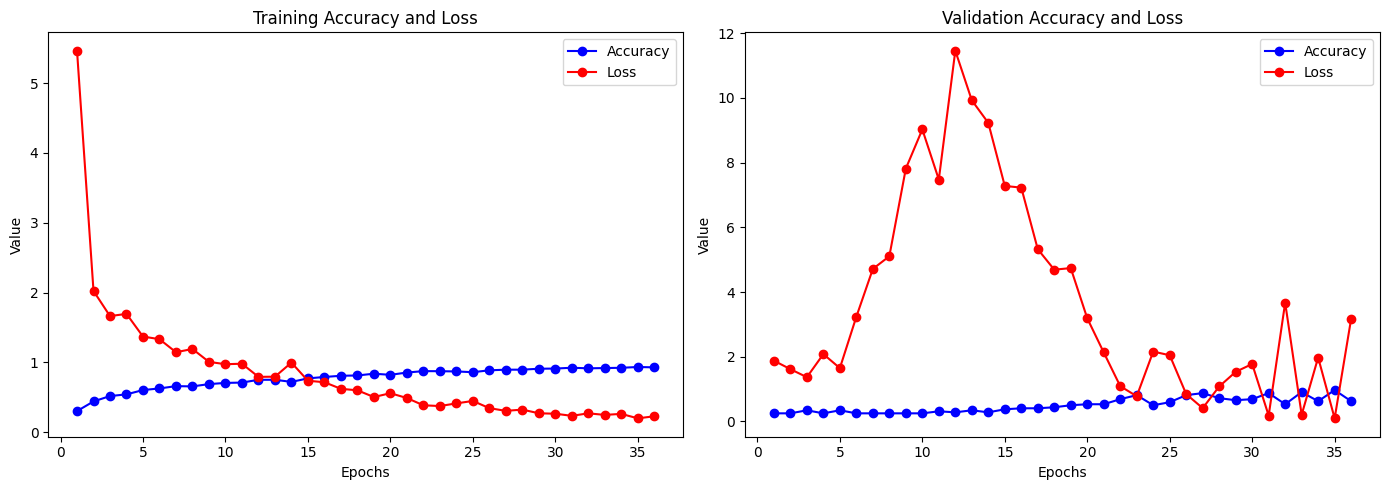

In [7]:
import matplotlib.pyplot as plt

# Assuming `history_cnn` is the History object returned by model.fit
# Extract the accuracy and loss values for training and validation
train_accuracy = history_cnn.history['accuracy']
val_accuracy = history_cnn.history['val_accuracy']
train_loss = history_cnn.history['loss']
val_loss = history_cnn.history['val_loss']

# Get the number of epochs
epochs = range(1, len(train_accuracy) + 1)

# Create a figure with two subplots side by side
plt.figure(figsize=(14, 5))

# Plot training accuracy and loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, 'bo-', label='Accuracy')
plt.plot(epochs, train_loss, 'ro-', label='Loss')
plt.title('Training Accuracy and Loss')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()

# Plot validation accuracy and loss
plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracy, 'bo-', label='Accuracy')
plt.plot(epochs, val_loss, 'ro-', label='Loss')
plt.title('Validation Accuracy and Loss')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.savefig("5_epochs_results.png", dpi=300)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


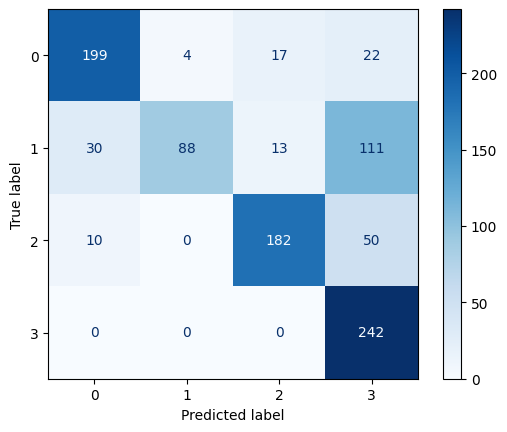

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.utils import to_categorical

# Make predictions on the test set
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1) # get the actual prediction

# Convert true labels to class indices
y_true = np.argmax(y_test, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(NUM_CLASSES))
disp.plot(cmap=plt.cm.Blues)
plt.savefig("5_confusion_matrix.png")



31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


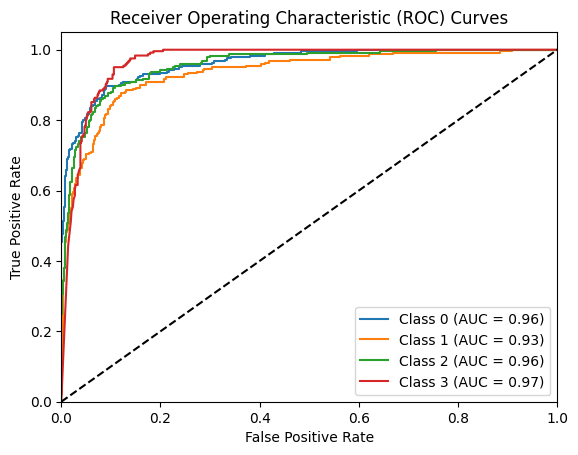

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Assuming NUM_CLASSES is the number of classes
# Binarize the output
y_test_binarized = label_binarize(y_test, classes=range(NUM_CLASSES))

# Make predictions on the test set
y_pred_probs = model.predict(x_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(NUM_CLASSES):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.savefig("5_roc_auc_curve.png", dpi=300)


In [10]:
import shap
import numpy as np
import matplotlib.pyplot as plt
import keras.backend as K

model.summary()
def get_layer_index_by_name(model, layer_name):
    for index, layer in enumerate(model.layers):
        if layer.name == layer_name:
            return index
    raise ValueError(f"Layer with name {layer_name} not found in the model.")

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 96)     │        55,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 24576)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │        98,308 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 519,086 (1.98 MB)

 Trainable params: 172,900 (675.39 KB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 345,802 (1.32 MB)

In [11]:
# # NEED TO MAKE THIS WORK!!!


# # Select a few images from your test set to explain
# to_explain = x_test[:2]  # Select two images to explain

# def map2layer(x, layer_name):
#     # Ensure x is a numpy array
#     x = np.array(x)
#     # Create a model that outputs the desired layer
#     intermediate_layer_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer(name=layer_name).input)
#     # Get the output of the intermediate layer
#     return intermediate_layer_model(x)

# # Specify the layer name to explain
# layer_name_to_explain = 'conv2d_5'  # Replace with the actual layer name

# # Create a SHAP GradientExplainer
# e = shap.GradientExplainer(
#     (model.get_layer(name=layer_name_to_explain).input, model.output),
#     map2layer(x_train[:100], layer_name_to_explain),  # Use a subset of training data
#     local_smoothing=0  # std dev of smoothing noise
# )

# # Compute SHAP values for the selected images
# shap_values, indexes = e.shap_values(map2layer(to_explain, layer_name_to_explain), ranked_outputs=2)

# # Plot the explanations
# shap.image_plot(shap_values, to_explain)


In [12]:
# img_index = 42
# image = x_test[img_index]

# pred=model.predict(np.expand_dims(image, axis=0))[0]
# for digit in range(10):
#         print("Probability for digit {}: {}".format(digit,pred[digit]))
# print("\nThe winner is {}".format(np.argmax(pred)))
# print("The correct class is {}\n".format(np.argmax(y_test[img_index])))

# plt.imshow(image.squeeze(),cmap='gray')
# plt.show()
# to explain



In [13]:
# Define constants
IMG_SIZE_RESNET = (224, 224)
BATCH_SIZE = 64
NUM_CLASSES = 4
SEED = 42

# Function to apply data augmentation
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    
    # Random zoom
    def random_zoom(img):
        scales = tf.random.uniform(shape=[], minval=0.8, maxval=1.2)
        new_height = tf.cast(scales * tf.cast(tf.shape(img)[0], tf.float32), tf.int32)
        new_width = tf.cast(scales * tf.cast(tf.shape(img)[1], tf.float32), tf.int32)
        img = tf.image.resize(img, [new_height, new_width])
        img = tf.image.resize_with_crop_or_pad(img, IMG_SIZE_RESNET[0], IMG_SIZE_RESNET[1])
        return img

    image = random_zoom(image)
    
    return image, label

# Load datasets
train_resnet = keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    seed=SEED,
    image_size=IMG_SIZE_RESNET,
    batch_size=BATCH_SIZE,
    color_mode='rgb'
)

val_resnet = keras.utils.image_dataset_from_directory(
    VAL_DIR,
    seed=SEED,
    image_size=IMG_SIZE_RESNET,
    batch_size=BATCH_SIZE,
    color_mode='rgb'
)

test_resnet = keras.utils.image_dataset_from_directory(
    TEST_DIR,
    seed=SEED,
    image_size=IMG_SIZE_RESNET,
    batch_size=BATCH_SIZE,
    color_mode='rgb'
)

# Apply data augmentation to the training dataset
train_resnet = train_resnet.map(augment)

Found 4000 files belonging to 4 classes.
Found 32 files belonging to 4 classes.
Found 968 files belonging to 4 classes.


In [14]:
# Load the pre-trained ResNet50 model without the top layers
resnet_base = applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)  # Adjust input shape for ResNet50
)

# Freeze the ResNet50 base to prevent its weights from being updated during training
# resnet_base.trainable = False

# Define the transfer learning model
model_resnet = keras.Sequential([
    resnet_base,
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(NUM_CLASSES, activation='softmax')
])
    
# Display the model's architecture
model_resnet.summary()

# Define the optimizer for ResNet50
optimizer_resnet = keras.optimizers.Adam(learning_rate=1e-6)

# Compile the ResNet50 transfer learning model
model_resnet.compile(
    optimizer=optimizer_resnet,
    loss='categorical_crossentropy',
    metrics=['accuracy', 'AUC']
)

# --------------------- Train the Custom CNN ---------------------

print("\nTraining Transfer Model with ResNet50...")
history_transfer = model_resnet.fit(
    x=x_train_resnet,
    y=y_train,
    batch_size=BATCH_SIZE,
    epochs=10,
    validation_data=(x_val_resnet, y_val),
    class_weight=class_weights_dict,
    # callbacks=[reduce_lr, early_stop, checkpoint_cnn]
)

# Evaluate the Custom CNN model on the test set
print("\nEvaluating Transfer Model with ResNet50 on Test Set...")
score_transfer = model_resnet.evaluate(x_test_resnet, y_test, verbose=1)
print('Test Loss:', score_transfer[0])
print('Test Accuracy:', score_transfer[1])
print('Test AUC:', score_transfer[2])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ ?                      │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)


Training Transfer Model with ResNet50...


NameError: name 'x_train_resnet' is not defined

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.utils import to_categorical

# Make predictions on the test set
y_pred_probs = model_resnet.predict(x_test_resnet)
y_pred = np.argmax(y_pred_probs, axis=1) # get the actual prediction

# Convert true labels to class indices
y_true = np.argmax(y_test, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(NUM_CLASSES))
disp.plot(cmap=plt.cm.Blues)
plt.savefig("5_confusion_matrix.png")

